# 2.1 확률 모델과 최대 우도 추정

B(x|p) = p^x(1-p)^(1-x)

\begin{align} f(p) &= \log{P(E|p)} \\\\ &= \log{\{ _{10}C_4 \ p^4 (1 - p)^6 \}} \\\\ &= \log{_{10}C_4} + 4\log{p} + 6\log{(1 - p)} \end{align}

# 2.2 확률적 경사 하강법
- 최대 우도 추정을 수치적으로 구하는 방법인 경사 하강법과 그것을 발전시킨 형태인 확률적 경사 하강법에 대해 설명한다

- lr이 높다 -> 빠르게 수렴, 진동 발생 가능성 있음
- lr이 낮다 -> 느리게 수렴

# 2.3 선형 회귀 모델
- 대표적인 확률 모델인 선형 회귀 모델에 대해 설명한다. 신경망도 사실은 선형 회귀 모델을 확장한 것이므로 이 모델을 잘 이해하면 신경망도 쉽게 이해할 수 있다.

## 2.3.2 파이토치로 선형 회귀 모델 만들기
- y = 1 + 2*x1 + 3*x2

In [37]:
import torch
# 참의 개수
w_true = torch.Tensor([1,2,3])

# X 데이터 준비, 절편을 위해 최초 차원에 1 추가
X = torch.cat([torch.ones(100,1),torch.randn(100,2)],1)

y = torch.mv(X,w_true) + torch.randn(100)*0.5

In [38]:
X.size()

torch.Size([100, 3])

In [39]:
# 난수에서 최적화시켜 나간다.
w = torch.randn(3,requires_grad=True)

In [40]:
gamma = 0.1

In [41]:
# 손실 함수의 로그
losses = []

# 100회 반복
for epoch in range(100):
    # 전회의 backward 메서드로 계산된 경사값을 초기화
    w.grad = None
    
    # 선형 모델로 y 예측값을 계산
    y_pred = torch.mv(X,w)
    
    # MSE loss와 w에 의한 미분을 계산
    loss = torch.mean((y - y_pred)**2)
    loss.backward()
    
    # - (학습률*기울기)로 w를 갱신
    w.data = w.data - gamma*w.grad.data
    
    losses.append(loss.item())

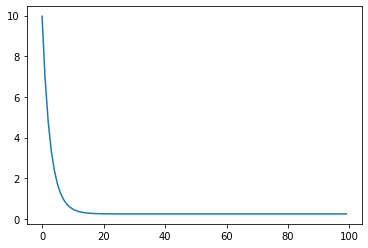

In [42]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(losses)

In [43]:
w

tensor([0.9392, 2.0717, 2.9029], requires_grad=True)

## 2.3.3 파이토치로 선형 회귀 모델 만들기
- nn: 모델 구축
- optim: 최적화

- nn.Linear: 선형 결합을 계산하는 클래스, nn.Module의 서브클래스다.
- nn.MSELoss: MSE를 계산하기 위한 클래스

In [44]:
from torch import nn, optim

# Linear 층을 작성, 이번에는 절편은 회귀계수에 포함하므로
# 입력 차원을 3으로 하고 bias를 False로 한다.

net = nn.Linear(in_features=3, out_features=1, bias=False)

# SGD의 최적화기상에서 정의한 네트워크의
# 파라미터를 전달해서 초기화
optimizer = optim.SGD(net.parameters(),lr=0.1)

# MSE loss 클래스
loss_fn = nn.MSELoss()

In [45]:
losses = []

for epoch in range(100):
    # 기울기 초기화
    optimizer.zero_grad()
    
    # 선형 모델로 y 예측값을 계산
    y_pred = net(X)
    
    # MSE loss 계산
    # y_pred는 (n,1)과 같은 shape를 지니고 있으므로 (n,)으로 변경할 필요가 있다.
    # view_as 를 하면 100,1 -> 100로 보인다
    loss = loss_fn(y_pred.view_as(y),y) # y_pred와 실제값 y의 오차를 MSE로 구한다.
    
    # loss의 w를 사용한 미분 계산
    loss.backward()
    
    # 경사를 갱신한다.
    optimizer.step()
    
    # 수렴 확인을 위해 loss 찍어두기
    losses.append(loss.item())

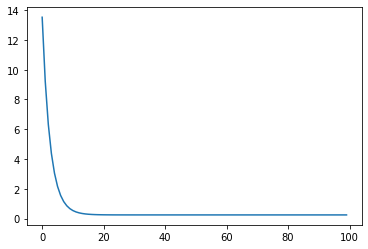

In [46]:
plt.plot(losses)

In [47]:
list(net.parameters())

[Parameter containing:
 tensor([[0.9392, 2.0717, 2.9029]], requires_grad=True)]

# 2.4 로지스틱 회귀
- 선형결합을 취한 후 시그모이드 함수를 적용해 [0,1] 사이의 값으로 변환

### 이진분류

In [48]:
import torch
from torch import nn, optim
from sklearn.datasets import load_iris
iris = load_iris()

In [66]:
# 총 0,1,2로 150개 이지만, 0,1만 하기 위해 :100
x = iris.data[:100]
y = iris.target[:100]

# Numpy의 ndarray pytorch의 tensor로 변환
x = torch.tensor(x, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)

In [65]:
iris.feature_names

['sepal length (cm)',
 'sepal width (cm)',
 'petal length (cm)',
 'petal width (cm)']

In [68]:
# iris 데이터는 4차원
net = nn.Linear(4,1)

# 시그모이드 함수를 적용해 두 클래스 분류를 위한 크로스 엔트로피 계산
loss_fn = nn.BCEWithLogitsLoss()

# SGD(약간 큰 학습률)
optimizer = optim.SGD(net.parameters(), lr=0.25)

In [71]:
losses = []

for epoch in range(100):
    # 경사값 초기화
    optimizer.zero_grad()
    
    # 예측
    y_pred = net(x)
    
    # 오차, 미분 계산
    loss = loss_fn(y_pred.view_as(y), y)
    loss.backward()
    
    # 경사 갱신
    optimizer.step()
    
    losses.append(loss.item())

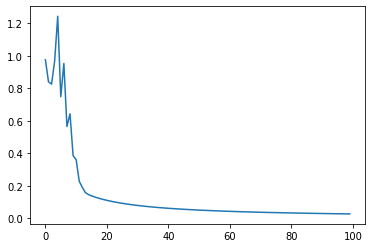

In [72]:
plt.plot(losses)

### 예측하는 법

In [73]:
# 선형 결합의 결과
h = net(x)

In [75]:
# y=1 일 확률을 계산
prob = nn.functional.sigmoid(h)

C:\Anaconda3\lib\site-packages\torch\nn\functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [77]:
# 0.5 이상이면 1, 아니면 0으로 예측
y_pred = prob>0.5

In [85]:
(y.byte() == y_pred.view_as(y)).sum().item()

100

### 다중분류

In [86]:
from sklearn.datasets import load_digits
digits = load_digits()

In [106]:
X.size()

torch.Size([1797, 64])

In [111]:
X = digits.data
y = digits.target

X = torch.tensor(X, dtype=torch.float32)
# 크로스엔트로피 loss함수는 y로 int를 받는다.
y = torch.tensor(y, dtype=torch.int64) 

# 출력은 10 차원
net = nn.Linear(X.size()[1],10) # 64 input, 1/10 out

# 소프트맥스 크로스 엔트로피
loss_fn = nn.CrossEntropyLoss()

# SGD
optimizer = optim.SGD(net.parameters(), lr=0.01)

In [112]:
dir(optim)

['ASGD',
 'Adadelta',
 'Adagrad',
 'Adam',
 'AdamW',
 'Adamax',
 'LBFGS',
 'Optimizer',
 'RMSprop',
 'Rprop',
 'SGD',
 'SparseAdam',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '_multi_tensor',
 'functional',
 'lr_scheduler',
 'swa_utils']

In [113]:
losses = []

for epoch in range(100):
    # 초기화
    # 예측
    # loss, grad 계산
    # 갱신
    
    optimizer.zero_grad()
    y_pred = net(X)
    
    loss = loss_fn(y_pred,y)
    loss.backward()
    
    optimizer.step()
    
    losses.append(loss.item())

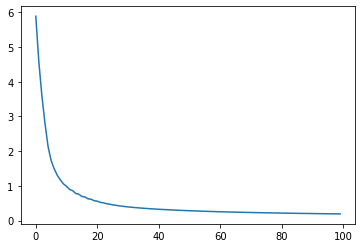

In [114]:
plt.plot(losses)

### 정답률 계산하기

In [115]:
# torch.max는 집계축을 지정하면 최댓값뿐만 아니라 그 위치도 반환한다
_, y_pred = torch.max(net(X),1)

# 정답률 계산
(y_pred==y).sum().item() / len(y)

0.9549248747913188